In [2]:
import tensorflow as tf
from tensorflow import keras

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
downsample_64x4x4_strides2 (Seq (None, 112, 112, 64) 3392        input_6[0][0]                    
__________________________________________________________________________________________________
downsample_128x4x4_strides2 (Se (None, 56, 56, 128)  131712      downsample_64x4x4_strides2[0][0] 
__________________________________________________________________________________________________
downsample_256x4x4_strides2 (Se (None, 28, 28, 256)  525568      downsample_128x4x4_strides2[0][0]
____________________________________________________________________________________________

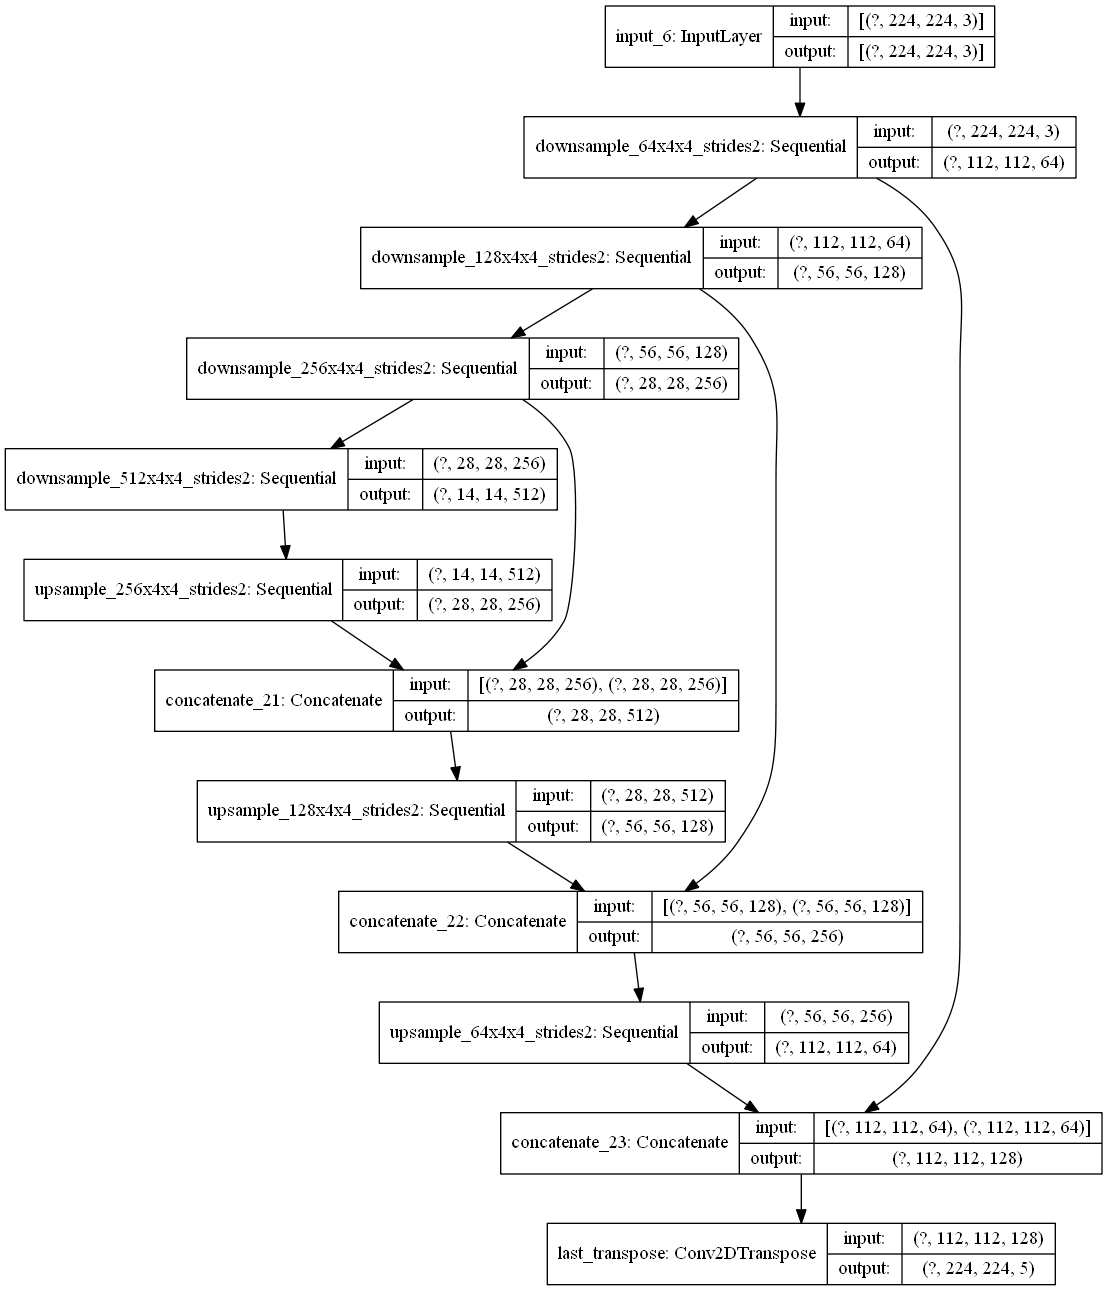

In [8]:
def downsample(filters, size):
    result = keras.models.Sequential(name="downsample_" + str(filters) + "x" + str(size) + "x" + str(size) + "_strides2")
    result.add(
        keras.layers.Conv2D(filters, size, padding="same", strides=2)
#         keras.layers.Conv2D(filters, size, padding="valid", dilation_rate=(2,2))
    )
    result.add(keras.layers.BatchNormalization())
    result.add(keras.layers.LeakyReLU())
#     keras.utils.plot_model(result, show_shapes=True)

    return result

def upsample(filters, size):
    result = keras.models.Sequential(name="upsample_" + str(filters) + "x" + str(size) + "x" + str(size) + "_strides2")
    result.add(
        keras.layers.Conv2DTranspose(filters, size, padding="same", strides=2)
    )
    result.add(keras.layers.BatchNormalization())
    result.add(keras.layers.Dropout(0.5))
    result.add(keras.layers.LeakyReLU())

    return result

def unet_generator(output_channels):
    down_stack = [
        downsample(64, 4),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    inputs = keras.layers.Input(shape=[224, 224, 3])
    concat = keras.layers.Concatenate()
    
    x = inputs
    
    # --- downsampling
    shortcuts = []
    for layer in down_stack:
        x = layer(x)
        shortcuts.append(x)
    
    shortcuts_rev = reversed(shortcuts[:-1])
#     for layer in shortcuts_rev:
#         print(layer)
#     print(shortcuts[0])
    
#     for up_layer, shortcut in zip(up_stack, shortcuts):
    for shortcut, up_layer in zip(shortcuts_rev, up_stack):
        x = up_layer(x)
        x = keras.layers.Concatenate()([x, shortcut])
        
    x = keras.layers.Conv2DTranspose(output_channels, 4, strides=2, padding="same", activation="tanh", name="last_transpose")(x)
    return keras.Model(inputs = inputs, outputs = x)

model = unet_generator(5)
model.summary()
keras.utils.plot_model(model, show_shapes=True)
# keras.utils.plot_model(model, show_shapes=True, expand_nested=True)
